In [5]:
import numpy as np
from numpy import sin, cos, sinh, cosh, pi, sqrt
from bikewheelcalc import BicycleWheel, Rim, Hub, Spoke
import bikewheellib as bl
from IPython.display import display

import bikewheellib as bl
import matplotlib.pyplot as plt

# Comment this line when committing code
# %matplotlib inline

In [2]:
rad_only = [True, False, False, False]
wheels = [BicycleWheel(), BicycleWheel(), BicycleWheel(), BicycleWheel()]

for i in range(len(wheels)):
    wheels[i].hub = Hub(diam1=0.05, width1=0.025, width2=0.025)

    R = 0.300
    GJ = 25.0
    EI1 = 100
    EI2 = GJ / 0.2

    wheels[i].rim = Rim(radius=R,
                        area=100e-6,
                        I11=GJ / 26.0e9,
                        I22=EI2 / 69.0e9,  # 266.0
                        I33=EI1 / 69.0e9,
                        Iw=0.0 / 69.0e9,
                        young_mod=69.0e9,
                        shear_mod=26.0e9)

wheels[0].lace_radial(n_spokes=36, diameter=1.7e-3, young_mod=200e9, offset=0.0)
wheels[0].apply_tension(0.001)

wheels[1].lace_cross(n_spokes=36, n_cross=1, diameter=1.7e-3, young_mod=200e9, offset=0.0)
wheels[1].apply_tension(0.001)

wheels[2].lace_cross(n_spokes=36, n_cross=2, diameter=1.7e-3, young_mod=200e9, offset=0.0)
wheels[2].apply_tension(0.001)

wheels[3].lace_cross(n_spokes=36, n_cross=3, diameter=1.7e-3, young_mod=200e9, offset=0.0)
wheels[3].apply_tension(0.001)

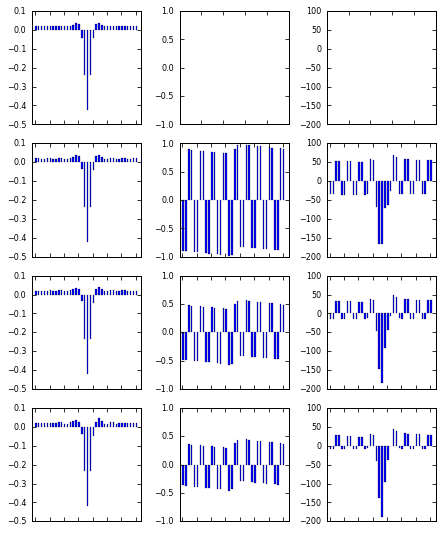

In [8]:
with plt.style.context(('seaborn-paper')):
    fig, ax = plt.subplots(ncols=3, nrows=len(wheels), figsize=(6.25, 7.5))
    
    # Spoke numbers
    s_num = np.arange(36)
    
    for i in range(len(wheels)):
        
        rr = bl.ModeMatrix(wheels[i], N=36)
        K = rr.calc_K_rim(buckling=False) + rr.calc_K_spk(smeared_spokes=True)
    
        # Calculate change in spoke tension for radial load
        F_ext = rr.calc_F_ext(np.array([np.pi]),
                          np.array([[0., 1., 0., 0.]]))
        d = np.linalg.solve(K, F_ext)

        delta_T = [-s.EA/s.length * s.n.dot(rr.B_theta(s.rim_pt[1], [0, 1, 2]).dot(d))
                   for s in wheels[i].spokes]

        ax[i, 0].set_xlim([-1, 37])
        ax[i, 0].bar(s_num, delta_T, width=0.5)


        if not rad_only[i]:
            # Calculate change in spoke tension for unit tangential load
            F_ext = rr.calc_F_ext(np.array([np.pi]),
                              np.array([[0., 0., 1., 0.]]))
            d = np.linalg.solve(K, F_ext)

            delta_T = [-s.EA/s.length * s.n.dot(rr.B_theta(s.rim_pt[1], [0, 1, 2]).dot(d))
                       for s in wheels[i].spokes]

            ax[i, 1].set_xlim([-1, 37])
            ax[i, 1].bar(s_num, delta_T, width=0.5)


            # Calculate change in spoke tension for a combined loading case
            F_ext = rr.calc_F_ext(np.array([np.pi]),
                              np.array([[0., 500., 50., 0.]]))
            d = np.linalg.solve(K, F_ext)

            delta_T = [-s.EA/s.length * s.n.dot(rr.B_theta(s.rim_pt[1], [0, 1, 2]).dot(d))
                       for s in wheels[i].spokes]

            ax[i, 2].set_xlim([-1, 37])
            ax[i, 2].bar(s_num, delta_T, width=0.5)

    for a in ax.flatten():
        a.set_xticklabels([])
    
    for i in range(len(wheels)):
        pass
        ax[i, 0].set_ylim(-0.5, 0.1)
        ax[i, 1].set_ylim(-1, 1)
        ax[i, 2].set_ylim(-200, 100)

plt.tight_layout()
plt.savefig('../figs/stress_analysis/_python_rad_tan_Tinf.pdf')
# plt.show()